In [39]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import curve_fit
from scipy import stats
import arviz as az

import pymc3 as pm
from pymc3.ode import DifferentialEquation

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 13, 'figure.figsize': (8, 6)})
import seaborn as sns

In [2]:
fluo = pd.read_csv('datasets/fluoOD-all.csv')
fluo.head()

,ECF,Intein,Ara,Cuma,0 days 00:00:00,0 days 00:20:00,0 days 00:40:00,0 days 01:00:00,0 days 01:20:00,0 days 01:40:00,...,0 days 21:00:00,0 days 21:20:00,0 days 21:40:00,0 days 22:00:00,0 days 22:20:00,0 days 22:40:00,0 days 23:00:00,0 days 23:20:00,0 days 23:40:00,1 days 00:00:00
0,e15,SspGyrB,0.0,0.0,-9563.50,4827.62,-2946.32,2144.51,2917.55,1794.39,...,1149.05,833.41,853.54,885.28,927.34,929.03,939.02,963.05,981.41,1042.26
1,e22,SspGyrB,0.0,0.0,-901.91,-612.44,-2021.98,-1082.24,1432.52,908.24,...,1160.50,850.36,873.56,922.43,923.53,927.85,939.77,891.52,920.52,956.05
2,e32,SspGyrB,0.0,0.0,-15040.52,14858.93,-2139.60,3282.42,2463.19,2427.71,...,953.25,649.42,699.29,721.20,706.81,687.56,744.65,734.43,771.71,817.92
3,e33,SspGyrB,0.0,0.0,210.74,19396.44,-210.92,3274.99,2949.69,2078.02,...,760.15,437.05,468.08,553.76,562.90,525.11,565.74,494.02,525.51,557.76
4,e34,SspGyrB,0.0,0.0,-687.59,16509.84,-801.39,3383.05,2385.70,2822.14,...,1250.40,937.08,982.35,1010.43,1032.36,1031.46,1024.81,1027.47,1009.38,1049.27


In [3]:
od = pd.read_csv('datasets/OD-all.csv')
od.head()

,ECF,Intein,Ara,Cuma,0 days 00:00:00,0 days 00:20:00,0 days 00:40:00,0 days 01:00:00,0 days 01:20:00,0 days 01:40:00,...,0 days 21:00:00,0 days 21:20:00,0 days 21:40:00,0 days 22:00:00,0 days 22:20:00,0 days 22:40:00,0 days 23:00:00,0 days 23:20:00,0 days 23:40:00,1 days 00:00:00
0,e15,SspGyrB,0.0,0.0,-0.009,0.017,-0.030,0.029,0.040,0.057,...,1.039,1.034,1.039,1.024,1.029,1.027,1.019,1.014,1.013,1.004
1,e22,SspGyrB,0.0,0.0,-0.025,0.031,-0.029,0.042,0.046,0.064,...,1.058,1.056,1.049,1.047,1.040,1.042,1.032,1.034,1.031,1.028
2,e32,SspGyrB,0.0,0.0,-0.005,0.007,-0.021,0.019,0.029,0.036,...,1.078,1.074,1.072,1.060,1.072,1.075,1.058,1.044,1.037,1.030
3,e33,SspGyrB,0.0,0.0,-0.040,0.005,-0.036,0.016,0.023,0.035,...,1.083,1.080,1.078,1.067,1.066,1.066,1.057,1.055,1.051,1.041
4,e34,SspGyrB,0.0,0.0,-0.032,0.005,-0.037,0.015,0.023,0.034,...,1.038,1.033,1.033,1.026,1.025,1.020,1.017,1.008,1.004,0.993


In [4]:
fluo = fluo.replace('n.a.', 0)
od = od.replace('n.a.', 0)
raw_fluo = fluo.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).astype(float)
raw_od = od.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).astype(float)
raw_val = raw_fluo * raw_od
df = pd.concat([fluo[['ECF', 'Intein', 'Ara', 'Cuma']], raw_val], axis=1)
df.head()

,ECF,Intein,Ara,Cuma,0 days 00:00:00,0 days 00:20:00,0 days 00:40:00,0 days 01:00:00,0 days 01:20:00,0 days 01:40:00,...,0 days 21:00:00,0 days 21:20:00,0 days 21:40:00,0 days 22:00:00,0 days 22:20:00,0 days 22:40:00,0 days 23:00:00,0 days 23:20:00,0 days 23:40:00,1 days 00:00:00
0,e15,SspGyrB,0.0,0.0,86.07150,82.06954,88.38960,62.19079,116.70200,102.28023,...,1193.86295,861.74594,886.82806,906.52672,954.23286,954.11381,956.86138,976.53270,994.16833,1046.42904
1,e22,SspGyrB,0.0,0.0,22.54775,-18.98564,58.63742,-45.45408,65.89592,58.12736,...,1227.80900,897.98016,916.36444,965.78421,960.47120,966.81970,969.84264,921.83168,949.05612,982.81940
2,e32,SspGyrB,0.0,0.0,75.20260,104.01251,44.93160,62.36598,71.43251,87.39756,...,1027.60350,697.47708,749.63888,764.47200,757.70032,739.12700,787.83970,766.74492,800.26327,842.45760
3,e33,SspGyrB,0.0,0.0,-8.42960,96.98220,7.59312,52.39984,67.84287,72.73070,...,823.24245,472.01400,504.59024,590.86192,600.05140,559.76726,597.98718,521.19110,552.31101,580.62816
4,e34,SspGyrB,0.0,0.0,22.00288,82.54920,29.65143,50.74575,54.87110,95.95276,...,1297.91520,968.00364,1014.76755,1036.70118,1058.16900,1052.08920,1042.23177,1035.68976,1013.41752,1041.92511


In [5]:
df2 = df[(df['Ara']==1) & (df['Cuma']==1)]
df2 = df2.set_index(df2['ECF'] + df2['Intein'])
df2 = df2.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).transpose()
df2['new_index'] = df2.index.str[7:12]
df2 = df2.set_index('new_index')
df2.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,...,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
new_index,,,,,,,,,,,,,,,,,,,,,
00:00,21.62500,14.10682,-10.20240,-14.73152,33.51864,54.76527,30.03510,30.74070,76.93035,98.94185,...,62.13312,17.90467,-6.91299,24.62000,76.44860,19.578000,-10.77699,24.425500,12.62616,31.97744
00:20,-101.37366,64.33200,63.38460,87.34615,175.67310,99.96154,89.73077,173.29753,127.39316,161.16140,...,-129.68964,-137.81250,-85.89522,62.82879,126.96154,92.153847,109.12588,107.615385,156.70011,160.07416
00:40,-52.95490,-38.89568,-37.80715,-46.18264,-12.37340,-2.86740,-48.26601,-15.48820,-18.92473,20.74640,...,-42.28900,-63.66528,-55.83582,-41.68976,-12.08031,-17.210700,-12.37340,-42.180800,13.03740,58.06452
01:00,-98.18847,-10.39050,23.09808,-15.46116,52.78819,24.15460,31.13992,42.37074,37.52530,56.37600,...,-87.81814,-119.76525,-93.24080,-7.20240,47.33113,-13.380450,5.12220,27.694420,7.57491,61.09570
01:20,-53.51717,13.43900,6.63873,4.95120,42.97700,18.45877,25.04068,60.71615,64.04811,27.90936,...,-61.15626,-95.25761,-49.29870,-0.86548,22.69449,7.170800,8.86480,-0.989730,33.28956,44.47770


In [6]:
df3 = od[(od['Ara']==1) & (od['Cuma']==1)]
df3 = df3.set_index(df3['ECF'] + df3['Intein'])
df3 = df3.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).transpose()
df3['new_index'] = df3.index.str[7:12]
df3 = df3.set_index('new_index')
df3.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,...,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
new_index,,,,,,,,,,,,,,,,,,,,,
00:00,0.025,0.026,0.040,0.032,0.024,0.0210,0.0300,0.010,0.015,-0.001,...,0.002,0.007,0.021,0.020,0.0100,0.0200,0.021,0.0250,0.024,0.016
00:20,0.018,0.004,0.004,0.001,-0.006,-0.0004,-0.0002,-0.007,-0.004,-0.005,...,0.018,0.021,0.017,0.003,-0.0004,0.0003,-0.002,-0.0001,-0.007,-0.008
00:40,0.019,0.016,0.017,0.014,0.010,0.0120,0.0130,0.007,0.011,0.008,...,0.013,0.018,0.017,0.014,0.0110,0.0130,0.010,0.0160,0.006,0.002
01:00,0.031,0.015,0.012,0.011,0.007,0.0100,0.0070,0.003,0.005,0.009,...,0.023,0.033,0.029,0.015,0.0110,0.0150,0.010,0.0130,0.007,0.002
01:20,0.037,0.020,0.021,0.016,0.011,0.0170,0.0140,0.005,0.007,0.018,...,0.022,0.037,0.033,0.022,0.0170,0.0260,0.016,0.0210,0.012,0.005


In [330]:
df4 = pd.concat([fluo[['ECF', 'Intein', 'Ara', 'Cuma']], raw_fluo], axis=1)
#df4 = df4[(df4['Ara']==1) & (df4['Cuma']==1)]
df4 = df4.set_index(df4['ECF'] + df4['Intein'])
df4 = df4.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).transpose()
df4['new_index'] = df4.index.str[7:12]
df4 = df4.set_index('new_index')
df4.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,...,e34STPhoRadA,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
new_index,,,,,,,,,,,,,,,,,,,,,
00:00,-9563.50,-901.91,-15040.52,210.74,-687.59,11.65,293.03,9982.55,-473.84,-583.80,...,-8107.83,2557.81,-329.19,1231.00,7644.86,978.90,-513.19,977.02,526.09,1998.59
00:20,4827.62,-612.44,14858.93,19396.44,16509.84,10017.25,5599.52,18206.06,12132.23,1267.13,...,25555.56,-6562.50,-5052.66,20942.93,-317403.85,307179.49,-54562.94,-1076153.85,-22385.73,-20009.27
00:40,-2946.32,-2021.98,-2139.60,-210.92,-801.39,-989.10,70.65,-100.92,-629.33,-1597.96,...,-96.29,-3536.96,-3284.46,-2977.84,-1098.21,-1323.90,-1237.34,-2636.30,2172.90,29032.26
01:00,2144.51,-1082.24,3282.42,3274.99,3383.05,3955.16,1768.19,4433.19,4793.88,476.28,...,971.66,-3629.25,-3215.20,-480.16,4302.83,-892.03,512.22,2130.34,1082.13,30547.85
01:20,2917.55,1432.52,2463.19,2949.69,2385.70,2439.83,1806.28,3332.48,2039.99,2315.41,...,453.39,-2574.53,-1493.90,-39.34,1334.97,275.80,554.05,-47.13,2774.13,8895.54


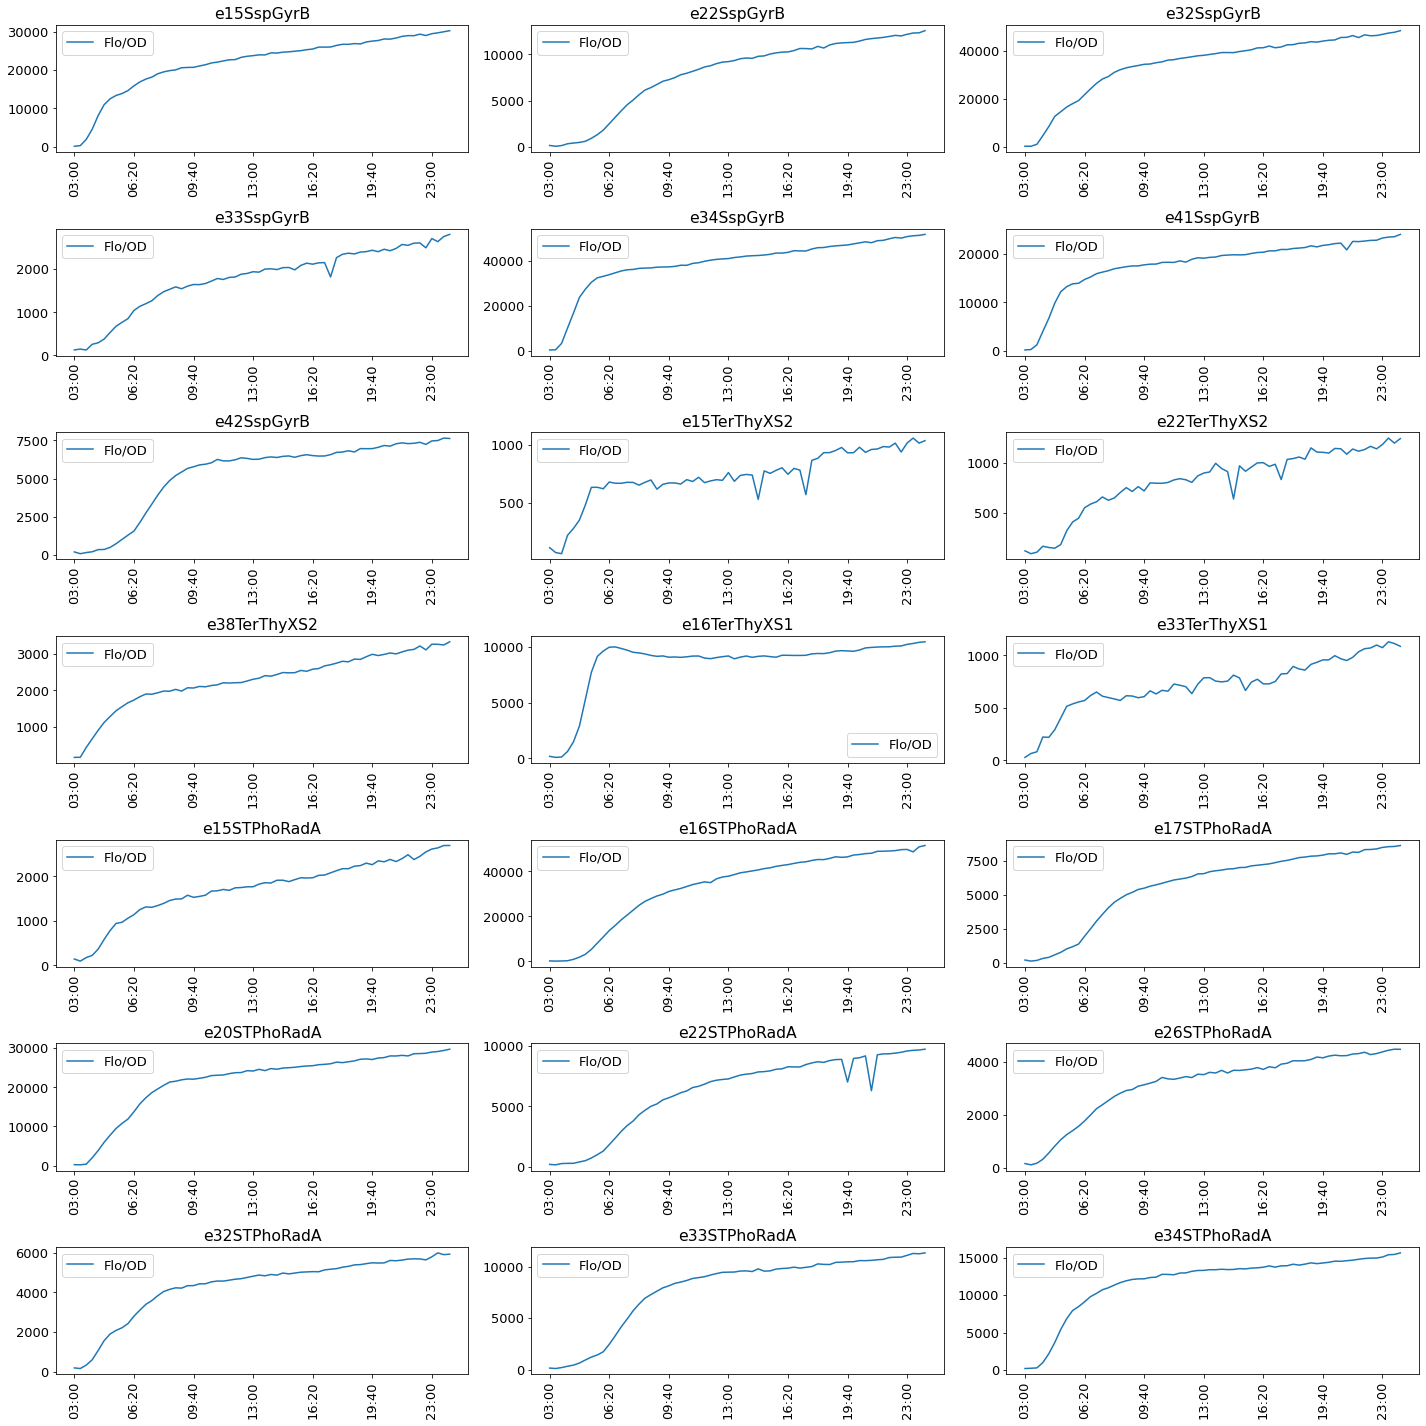

In [328]:
plt.figure(figsize=(20, 20))
num_col = 3
num_vars = len(df4.columns.tolist())
num_row = int(np.ceil(num_vars)/num_col)
for i in range(num_vars):
    plt.subplot(num_row, num_col, i+1)
    df4[df4.columns[i]][9:].plot(label='Flo/OD')
    plt.legend()
    plt.title(df4.columns[i])
    plt.xticks(rotation=90)
    plt.xlabel(None)
plt.tight_layout()
plt.show()

In [329]:
def solveODE_ConstantInducer(y, t, inducer, param):
    
    # Variables
    ECFn = y[0]
    ECFc = y[1]
    ECF = y[2]
    GFP = y[3]
    # Parameters
    n = param[0]
    K_ind = param[1]
    syn_ECFn = param[2]
    deg_ECFn = param[3]
    syn_ECFc = param[4]
    deg_ECFc = param[5]
    syn_ECF = param[6]
    deg_ECF = param[7]
    syn_GFP = param[8]
    deg_GFP = param[9]

    # Differential equations
    dECFn_dt = syn_ECFn - (deg_ECFn + d * ECFn)
    dECFc_dt = syn_ECFc - (deg_ECFc * ECFc)
    dECF_dt = syn_ECF * ECFn * ECFc - (deg_ECF * ECF)
    dGFP_dt = syn_GFP - (deg_GFP * GFP)
    #dPep_dt = syn_Pep-(deg_Pep*Pep)

    return [dECFn_dt, dECFc_dt, dECF_dt, dGFP_dt]

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,...,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
new_index,,,,,,,,,,,,,,,,,,,,,
03:00,115.24,185.89,222.19,128.63,356.46,196.61,193.78,113.31,119.17,160.03,...,29.01,139.48,251.26,207.69,247.86,181.11,152.22,197.53,156.04,220.71
03:20,286.08,98.16,197.08,147.20,456.83,291.82,78.85,71.56,90.94,163.27,...,66.06,92.32,161.18,128.24,211.65,148.05,105.57,167.09,112.76,255.90
03:40,1911.59,172.64,1029.89,126.75,3283.12,1259.26,152.73,61.65,106.08,434.12,...,82.33,171.47,215.16,179.45,385.53,251.97,165.12,339.31,204.54,305.46
04:00,4556.67,366.89,4634.61,258.36,10124.14,4022.35,203.26,219.82,165.24,671.25,...,223.12,221.10,329.08,322.75,2002.24,268.57,316.18,609.13,331.36,1007.11
04:20,8131.10,446.73,8425.00,293.78,16855.27,6712.30,345.13,278.70,152.61,904.21,...,220.00,362.08,942.79,404.76,3860.45,273.57,554.06,1078.72,443.48,2196.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:40,28977.69,11982.98,46427.42,2495.30,50236.03,22795.14,7234.22,935.77,1136.60,3109.77,...,1099.45,2550.23,49553.75,8365.92,28650.95,9481.97,4317.21,5637.73,10921.66,14934.44
23:00,29457.45,12160.88,46892.98,2709.79,50916.80,23253.69,7462.75,1013.12,1179.83,3265.81,...,1074.73,2614.72,49640.18,8478.13,28966.47,9590.03,4380.06,5793.26,11096.84,15068.47
23:20,29679.87,12294.84,47424.41,2637.92,51268.89,23441.92,7488.58,1055.48,1244.02,3263.64,...,1130.53,2640.20,48565.83,8529.23,29093.03,9643.21,4442.93,5989.43,11276.10,15372.19


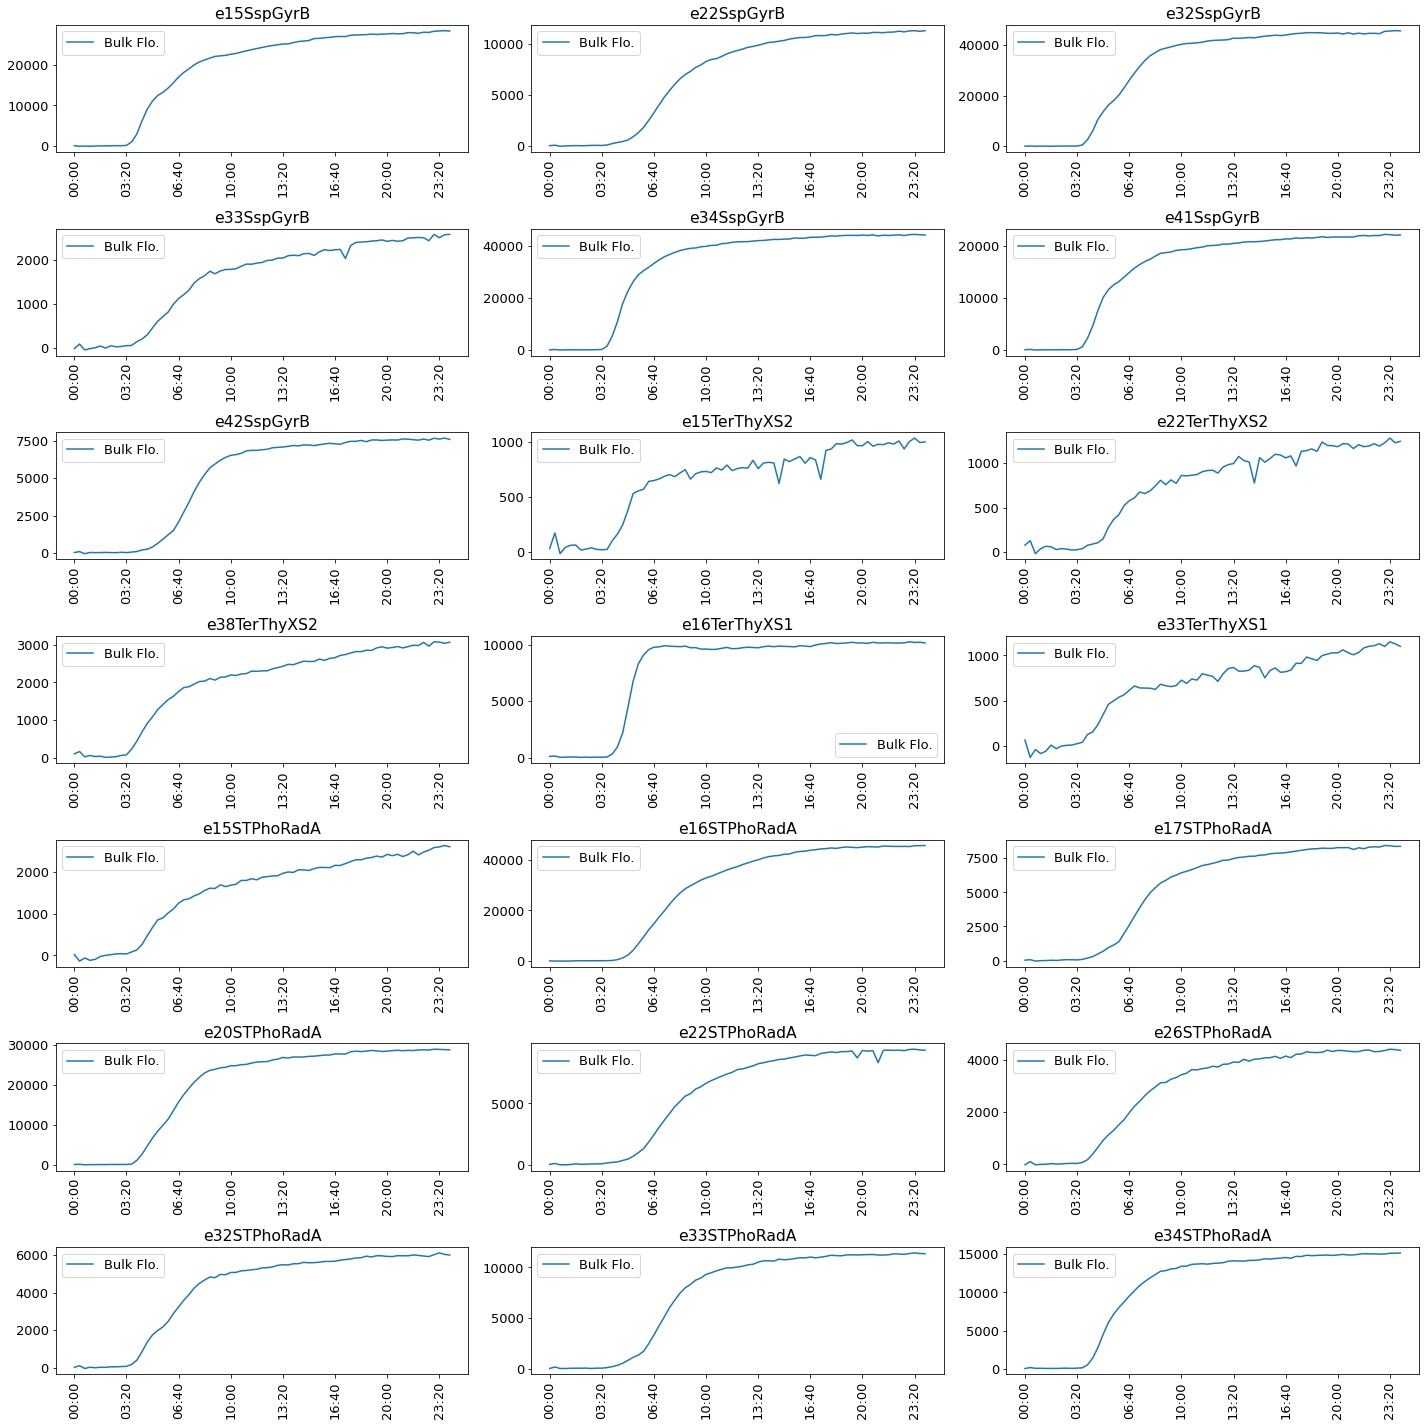

In [7]:
plt.figure(figsize=(20, 20))
num_col = 3
num_vars = len(df2.columns.tolist())
num_row = int(np.ceil(num_vars)/num_col)
for i in range(num_vars):
    plt.subplot(num_row, num_col, i+1)
    df2[df2.columns[i]].plot(label='Bulk Flo.')
    plt.legend()
    plt.title(df2.columns[i])
    plt.xticks(rotation=90)
    plt.xlabel(None)
plt.tight_layout()
plt.show()

$\hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j} $

$$\require{mhchem}$$
## $\ce{Na2SO4 ->[H2O] Na+ + SO4^2-}$

[0.30576577 1.04091593]


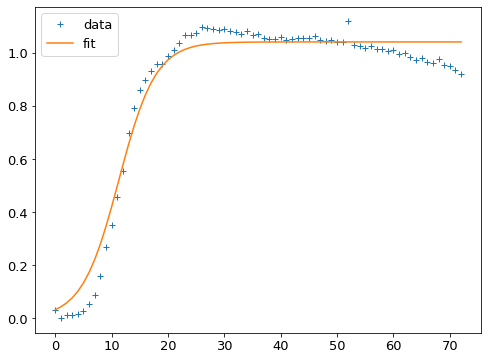

In [297]:
col = 3
odata = df3[df3.columns[col]]
t = list(range(0, len(odata.index)))

def testfunc(t, k1, k2):
    
    def cell_density_model(OD, t, max_growth_rate, max_carry_capacity):
        dOD = (max_growth_rate * (1 - (OD[0]/max_carry_capacity))) * OD[0]
        return dOD
    
    def hill_equation(x, top, bottom, K, n):
        return bottom + (top - bottom) * x**n / (K**n + x**n)
    
    Ca0 = np.abs(odata[0])
    rates = (k1, k2)
    Casol = odeint(cell_density_model, Ca0, t, rates)
    return Casol[:,0]

k_fit, kcov = curve_fit(testfunc, t, odata)
print(k_fit)
fit = testfunc(t, *k_fit)

plt.plot(t, odata, '+', label='data')
plt.plot(t, fit, '-', label='fit')
plt.legend(loc='best')
plt.show()

[0.30576577 1.04091593]


<ipython-input-309-f91e12b96f08>:11: RuntimeWarning: invalid value encountered in double_scalars
  return x**n / (K**n + x**n)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-309-f91e12b96f08>:35: RuntimeWarning: overflow encountered in double_scalars
  dECF = ae * ECF_n * ECF_c - (de + (mgr * (1 - (OD/mgc)))) * ECF
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-309-f91e12b96f08>:11: RuntimeWarning: overflow encountered in double_scalars
  return x**n / (K**n + x**n)


[ 7.25923794e+00  1.22019206e-01  3.94659470e+00  2.05769289e-01
  1.58485291e+00 -5.85333353e-01  1.42790251e+02  5.37866532e-02
  2.65919499e-04  7.20962110e+00]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


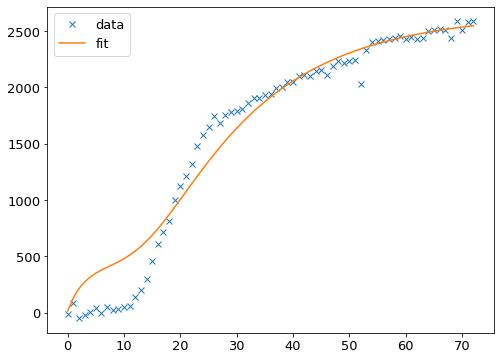

In [309]:
def growth(OD, max_growth_rate, max_carry_capacity):
    return max_growth_rate * (1 - (OD/max_carry_capacity)) * OD

def activation(Inducer, b0, b1, K, n):
    return (b0 + b1 * (K**n * Inducer**n)) / (1 +  (K**n * Inducer**n))

def hill_equation(x, top, bottom, K, n):
    return bottom + (top - bottom) * x**n / (K**n + x**n)

def simplest_hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def fitfunc(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn, xCa0):
    
    an = xan
    dn = xdn
    ac = xac
    dc = xdc
    ae = xae
    de = xde
    ag = xag
    dg = xdg
    mgr = k_fit[0]
    mgc = k_fit[1]
    K = xK
    n = xn
    Ca0 = xCa0
    
    def andGate(y, t):
        
        [OD, ECF_n, ECF_c, ECF, GFP] = y
        dOD = mgr * (1 - (OD/mgc)) * OD
        dECF_n = an - (dn + (mgr * (1 - (OD/mgc)))) * ECF_n
        dECF_c = ac - (dc + (mgr * (1 - (OD/mgc)))) * ECF_c
        dECF = ae * ECF_n * ECF_c - (de + (mgr * (1 - (OD/mgc)))) * ECF
        dGFP = ag * simplest_hill_equation(ECF, K, n)  - (dg + (mgr * (1 - (OD/mgc)))) * GFP
        
        return [dOD, dECF_n, dECF_c, dECF, dGFP]
    
    Casol = odeint(andGate, Ca0, t)
    return Casol[:,4]

def modelfit(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn):
    return fitfunc(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn, Ca0)

def testfunc(t, k1, k2):
    
    def cell_density_model(OD, t, max_growth_rate, max_carry_capacity):
        dOD = (max_growth_rate * (1 - (OD[0]/max_carry_capacity))) * OD[0]
        return dOD
    
    def hill_equation(x, top, bottom, K, n):
        return bottom + (top - bottom) * x**n / (K**n + x**n)
    
    Ca0 = np.abs(odata[0])
    rates = (k1, k2)
    Casol = odeint(cell_density_model, Ca0, t, rates)
    return Casol[:,0]

col = 3
odata = df3[df3.columns[col]]
t = list(range(0, len(odata.index)))
k_fit, kcov = curve_fit(testfunc, t, odata)
print(k_fit)
#fit = testfunc(t, *k_fit)

fdata = df2[df2.columns[col]]
t = list(range(0, len(fdata.index)))

Ca0 = np.abs([odata[0], 0.01, 0.01, 0.01, fdata[0]])
params, cov = curve_fit(modelfit, t, fdata)
fit = fitfunc(t, *params, Ca0)
print(params)

plt.plot(t, fdata, 'x', label='data')
plt.plot(t, fit, '-', label='fit')
plt.legend(loc='best')
plt.show()

/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[8.75461756e+02 4.67097652e-02 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


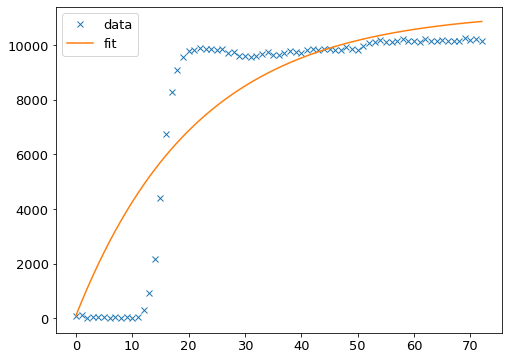

In [218]:
def activation(Inducer, b0, b1, K, n):
    return (b0 + b1 * (K**n * Inducer**n)) / (1 +  (K**n * Inducer**n))

def fitfunc(t, xan, xdn, xb0, xb1, xK, xn, xCa0):
    
    a = xan
    d = xdn
    b0 = xb0
    b1 = xb1
    K = xK
    n = xn
    Ca0 = xCa0
    
    def andGate(y, t):
        
        [GFP, Ind] = y
        dInd = Ind
        dGFP = a * activation(Ind, 0.1, 0.6, 1.0, 1.0)  - d * GFP
        
        return [dGFP, dInd]
    
    Casol = odeint(andGate, Ca0, t)
    return Casol[:,0]

def modelfit(t, xan, xdn, xb0, xb1, xK, xn):
    return fitfunc(t, xan, xdn, xb0, xb1, xK, xn, Ca0)

fdata = df2[df2.columns[col]]
t = list(range(0, len(fdata.index)))

Ca0 = np.abs([fdata[0], 100])
params, cov = curve_fit(modelfit, t, fdata)
fit = fitfunc(t, *params, Ca0)
print(params)

plt.plot(t, fdata, 'x', label='data')
plt.plot(t, fit, '-', label='fit')
plt.legend(loc='best')
plt.show()

#### Original model

In [ ]:
def fitfunc(t, xfpra, xrpra, xkma, xkpa, xdma, xda, xfprb, xrprb, xkmb, xkpb, xdmb, xdb, xkspl, xfprc, xrprc, xkmc, xkpc, xdmc, xdc, xdic, xCa0):
    
    fpra = xfpra
    rpra = xrpra
    kma = xkma
    kpa = xkpa
    dma = xdma
    da = xda
    fprb = xfprb
    rprb = xrprb
    kmb = xkmb
    kpb = xkpb
    dmb = xdmb
    db = xdb
    kspl = xkspl
    fprc = xfprc
    rprc = xrprc
    kmc = xkmc
    kpc = xkpc
    dmc = xdmc
    dc = xdc
    dic = xdic
    Ca0 = xCa0
    
    def andGate(y, t):
        [Ia, pA, pAIa, mA, A, Ib, pB, pBIb, mB, B, Ic, w, pC, pCIc, mC, C] = y
        Ia_ = -1 * fpra * Ia * pA + rpra * pAIa
        pA_ = -1 * fpra * Ia * pA + rpra * pAIa
        pAIa_ = fpra * Ia * pA + -1 * rpra * pAIa + -1 * kma * pAIa + kma * pAIa
        mA_ = kma * pAIa + -1 * kpa * mA + kpa * mA + -1 * dma * mA
        A_ = kpa * mA + -1 * da * A + -1 * kspl * A * B
        Ib_ = -1 * fprb * Ib * pB + rprb * pBIb
        pB_ = -1 * fprb * Ib * pB + rprb * pBIb
        pBIb_ = fprb * Ib * pB + -1 * rprb * pBIb + -1 * kmb * pBIb + kmb * pBIb
        mB_ = kmb * pBIb + -1 * kpb * mB + kpb * mB + -1 * dmb * mB
        B_ = kpb * mB + -1 * db * B + -1 * kspl * A * B
        Ic_ = kspl * A * B + -1 * fprc * Ic * pC + rprc * pCIc + -1 * dic * Ic
        w_ = kspl * A * B
        pC_ = -1 * fprc * Ic * pC + rprc * pCIc
        pCIc_ = fprc * Ic * pC + -1 * rprc * pCIc + -1 * kmc * pCIc + kmc * pCIc
        mC_ = kmc * pCIc + -1 * kpc * mC + kpc * mC + -1 * dmc * mC
        C_ = kpc * mC + -1 * dc * C
        return [Ia_, pA_, pAIa_, mA_, A_, Ib_, pB_, pBIb_, mB_, B_, Ic_, w_, pC_, pCIc_, mC_, C_]
    
    Casol = odeint(andGate, Ca0, t)
    return Casol[:,15]

def modelfit(t, fpra, rpra, kma, kpa, dma, da, fprb, rprb, kmb, kpb, dmb, db, kspl, fprc, rprc, kmc, kpc, dmc, dc, dic):
    return fitfunc(t, fpra, rpra, kma, kpa, dma, da, fprb, rprb, kmb, kpb, dmb, db, kspl, fprc, rprc, kmc, kpc, dmc, dc, dic, Ca0)

#### Growth model

In [ ]:
def growthfunc(t, xmgr, xmcc, xtlag, xCa0):
    
    max_growth_rate = xmgr
    max_carry_capacity = xmcc
    tlag = xtlag
    Ca0 = xCa0
    
    def cell_density_model(y, t):
        [OD] = y
        dOD = max_growth_rate * (1 - (OD/max_carry_capacity)) / (1 + np.exp(-4* (t - tlag)))
        return [dOD]
    
    Casol = odeint(cell_density_model, Ca0, t)
    return Casol[:,0]

def modelfit2(t, mgr, mcc, tlag):
    return growthfunc(t, mgr, mcc, tlag, Ca0)

#### New Model

In [320]:
def growth(OD, max_growth_rate, max_carry_capacity):
    return max_growth_rate * (1 - (OD/max_carry_capacity)) * OD

def activation(Inducer, b0, b1, K, n):
    return (b0 + b1 * (K**n * Inducer**n)) / (1 +  (K**n * Inducer**n))

def hill_equation(x, top, bottom, K, n):
    return bottom + (top - bottom) * x**n / (K**n + x**n)

def simplest_hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def fitfunc(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn, xCa0):
    
    an = xan
    dn = xdn
    ac = xac
    dc = xdc
    ae = xae
    de = xde
    ag = xag
    dg = xdg
    mgr = g_params[0]
    mgc = g_params[1]
    K = xK
    n = xn
    Ca0 = xCa0
    
    def andGate(y, t):
        
        [OD, ECF_n, ECF_c, ECF, GFP] = y
        dOD = mgr * (1 - (OD/mgc)) * OD
        '''
        dECF_n = an - (dn + (mgr * (1 - (OD/mgc)))) * ECF_n
        dECF_c = ac - (dc + (mgr * (1 - (OD/mgc)))) * ECF_c
        dECF = ae * ECF_n * ECF_c - (de + (mgr * (1 - (OD/mgc)))) * ECF
        dGFP = ag * simplest_hill_equation(ECF, K, n)  - (dg + (mgr * (1 - (OD/mgc)))) * GFP
        '''
        
        dECF_n = an - dn * ECF_n
        dECF_c = ac - dc * ECF_c
        dECF = ae * ECF_n * ECF_c - de * ECF
        dGFP = ag * simplest_hill_equation(ECF, K, n)  - dg * GFP
        
        return [dOD, dECF_n, dECF_c, dECF, dGFP]
    
    Casol = odeint(andGate, Ca0, t)
    return Casol[:,4]

def modelfit(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn):
    return fitfunc(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn, Ca0)

temp = '''
    col = 3

    fdata = df2[df2.columns[col]]
    tf = list(range(0, len(fdata.index)))
    odata = df3[df3.columns[col]]
    to = list(range(0, len(odata.index)))

    g_params, _ = curve_fit(growth_fit, to, odata)
    print(g_params)

    Ca0 = np.abs([odata[0], 0.01, 0.01, 0.01, fdata[0]])
    f_params, _ = curve_fit(fluo_fit, tf, fdata)
    fit = gate_model(tf, *f_params, Ca0)
    print(f_params)

    plt.plot(t, fdata, 'x', label='data')
    plt.plot(t, fit, '-', label='fit')
    plt.legend(loc='best')
    plt.show()
    '''

In [321]:
def SquaredError(InitialParameterGuess, tf, fdata):
    
    try:
        #Some guesses will result in an error or an invalid integration 
        #this ensures that the error is estimated only for valid solutions 
        params, _ = curve_fit(fluo_fit, tf, fdata, p0=InitialParameterGuess)
        cSolution = gate_model(tf, *params, Ca0)
    
        error=[(val-sal)**2 for val, sal in zip(cSolution, fdata)]
        
    except RuntimeError:
        
        #Based on the scale of the data the following list of values will be large enough to be rejected as a solution 
        error=[1000000]
    
    return sum(error)

In [322]:
def RandomSearch(Iterations, tf, fdata):
    
    nIt=Iterations 
    GuessContainer=[]
    ErrorContainer=[]
    
    for k in range(nIt):
        
        lGuess=[np.random.uniform(low=0,high=1) for val in range(12)]
        lerror=SquaredError(lGuess, tf, fdata)
        
        GuessContainer.append(lGuess) #Contains the list of random initial values 
        ErrorContainer.append(lerror) #List of the errors 
    
    minError=np.min(ErrorContainer) #Min error value 
    minLocation=[j for j in range(nIt) if ErrorContainer[j]==minError] #Returns the location of the min value in the list
    
    bestGuess=GuessContainer[minLocation[0]] #Best initial value guess 
    
    return ErrorContainer, bestGuess

0 e15SspGyrB
[0.34619353 1.03486967]


<ipython-input-321-ce422324b975>:9: RuntimeWarning: overflow encountered in double_scalars
  error=[(val-sal)**2 for val, sal in zip(cSolution, fdata)]


1 e22SspGyrB
[0.33688166 1.02719943]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-321-ce422324b975>:9: RuntimeWarning: overflow encountered in double_scalars
  error=[(val-sal)**2 for val, sal in zip(cSolution, fdata)]


2 e32SspGyrB
[0.29733921 1.07743793]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-177-b32cbf9ebc54>:46: RuntimeWarning: overflow encountered in double_scalars
  dECF = ae * ECF_n * ECF_c - (de + dOD) * ECF
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-177-b32cbf9ebc54>:46: RuntimeWarning: invalid value

3 e33SspGyrB
[0.30576577 1.04091593]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


4 e34SspGyrB
[0.32889502 0.97794109]


<ipython-input-177-b32cbf9ebc54>:46: RuntimeWarning: overflow encountered in double_scalars
  dECF = ae * ECF_n * ECF_c - (de + dOD) * ECF
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-177-b32cbf9ebc54>:45: RuntimeWarning: overflow enco

5 e41SspGyrB
[0.33940594 1.03212006]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


6 e42SspGyrB
[0.28695792 1.09364991]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-321-ce422324b975>:9: RuntimeWarning: overflow encountered in double_scalars
  error=[(val-sal)**2 for val, sal in zip(cSolution, fdata)]


Exception. Skipped!
7 e15TerThyXS2
[0.36859393 1.06507603]
8 e22TerThyXS2
[0.33716728 1.0863703 ]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:787: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-321-ce422324b975>:9: RuntimeWarning: overflow encountered in double_scalars
  error=[(val-sal)**2 for val, sal in zip(cSolution, fdata)]


Exception. Skipped!
9 e38TerThyXS2
[0.64300197 0.99734606]
Exception. Skipped!
10 e16TerThyXS1
[0.44087883 1.05042117]
Exception. Skipped!
11 e33TerThyXS1
[0.52818738 1.07613131]
Exception. Skipped!
12 e15STPhoRadA
[0.43836935 1.04967374]
13 e16STPhoRadA
[0.30860464 0.99650675]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-321-ce422324b975>:9: RuntimeWarning: overflow encountered in double_scalars
  error=[(val-sal)**2 for val, sal in zip(cSolution, fdata)]


14 e17STPhoRadA
[0.34576407 1.08315413]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-321-ce422324b975>:9: RuntimeWarning: overflow encountered in double_scalars
  error=[(val-sal)**2 for val, sal in zip(cSolution, fdata)]


15 e20STPhoRadA
[0.3969045  1.06046305]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:787: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-321-ce422324b975>:9: RuntimeWarning: overflow encountered in double_scalars
  error=[(val-sal)**2 for val, sal in zip(cSolution, fdata)]


Exception. Skipped!
16 e22STPhoRadA
[0.3659505  1.08083184]
17 e26STPhoRadA
[0.34145909 1.05684982]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-177-b32cbf9ebc54>:46: RuntimeWarning: overflow encountered in double_scalars
  dECF = ae * ECF_n * ECF_c - (de + dOD) * ECF
<ipython-input-177-b32cbf9ebc54>:46: RuntimeWarning: invalid value encountered in double_scalars
  dECF = ae * ECF_n * ECF_c - (de + dOD) * ECF
<ipython-input-177-b32cbf9ebc54>:44: RuntimeWarning: overflow encountered in double_scalars
  dECF_n = an - (dn + dOD) * ECF_n
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9

18 e32STPhoRadA
[0.34122005 1.10777034]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Exception. Skipped!
19 e33STPhoRadA
[0.32759855 1.0874275 ]


<ipython-input-177-b32cbf9ebc54>:46: RuntimeWarning: overflow encountered in double_scalars
  dECF = ae * ECF_n * ECF_c - (de + dOD) * ECF
<ipython-input-177-b32cbf9ebc54>:46: RuntimeWarning: invalid value encountered in double_scalars
  dECF = ae * ECF_n * ECF_c - (de + dOD) * ECF
<ipython-input-177-b32cbf9ebc54>:44: RuntimeWarning: overflow encountered in double_scalars
  dECF_n = an - (dn + dOD) * ECF_n
/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Exception. Skipped!
20 e34STPhoRadA
[0.34824331 1.04859019]


<ipython-input-321-ce422324b975>:9: RuntimeWarning: overflow encountered in double_scalars
  error=[(val-sal)**2 for val, sal in zip(cSolution, fdata)]


Exception. Skipped!


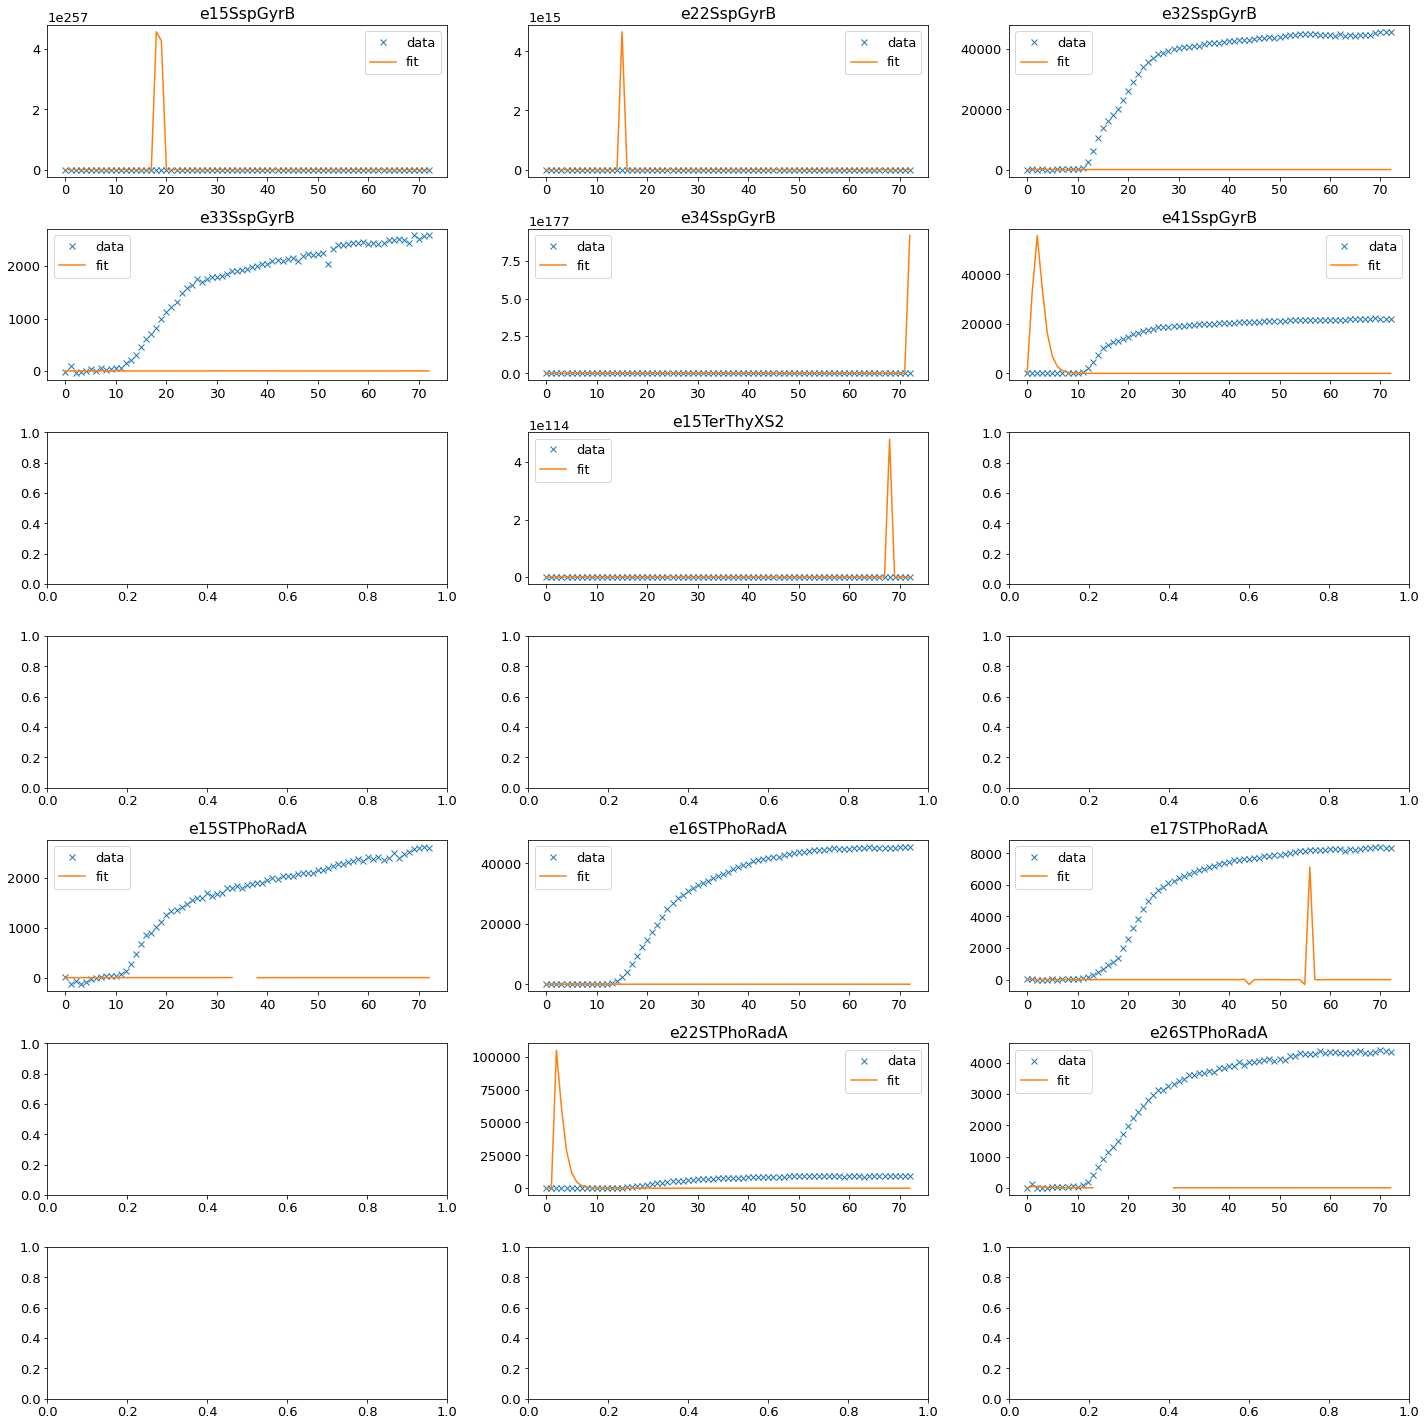

In [324]:
output_params = []
plt.figure(figsize=(20, 20))
num_col = 3
num_vars = len(df2.columns.tolist())
num_row = int(np.ceil(num_vars)/num_col)

#plotting
for i in range(num_vars):
    
    print(i, df2.columns[i])
    plt.subplot(num_row, num_col, i+1)
    
    
    fdata = df2[df2.columns[i]]
    tf = list(range(0, len(fdata.index)))
    odata = df3[df3.columns[i]]
    to = list(range(0, len(odata.index)))

    g_params, _ = curve_fit(growth_fit, to, odata)
    print(g_params)

    Ca0 = np.abs([odata[0], 0.01, 0.01, 0.01, fdata[0]])
    
    #find the best initial values
    try:
        errs, bG = RandomSearch(3, tf, fdata)
    except:
        print('Exception. Skipped!')
        continue
    
    f_params, _ = curve_fit(fluo_fit, tf, fdata)
    output_params.append((df2.columns[i], f_params))
    fit = gate_model(tf, *f_params, Ca0)
    #print(f_params)

    plt.plot(t, fdata, 'x', label='data')
    plt.plot(t, fit, '-', label='fit')
    plt.legend(loc='best')
    #plt.show()
    
    
    #cdata = df2[df2.columns[i]]
    #t = list(range(0, len(cdata.index)))
    #Ca0 = [500, 800, 0.0, 0.0, 0.0,
    #      500, 800, 0.0, 0.0, 0.0,
    #      0.0, 0.0, 800, 0.0, 0.0, 0.0]
    
    #apply the best initial values
    #params, cov=curve_fit(modelfit, t, cdata, p0=bG)
    #output_params.append((df2.columns[i], params))
    #solution=fitfunc(t, *params, Ca0)
    
    #plt.plot(t,cdata,'ro',label='data')
    #plt.plot(t,solution,'b-',label='fit')
    #plt.legend(loc='best')

    plt.title(df2.columns[i])
    
plt.tight_layout()
plt.show()

In [ ]:
num_vars = len(df3.columns.tolist())

nIt=3
GuessContainer=[]
ErrorContainer=[]

for k in range(nIt):

    lerror_sum = 0
    lGuess_all = []
    for i in range(num_vars):
    
        print(i, df3.columns[i])

        cdata = df3[df3.columns[i]]
        t = list(range(0, len(cdata.index)))
        '''
        Ca0 = [208000, 100, 0.0, 0.0, 0.0,
              100, 100, 0.0, 0.0, 0.0,
              0.0, 0.0, 100, 0.0, 0.0, 0.0]
        '''
        Ca0 = np.abs(cdata[0])
        lGuess=[np.random.uniform(low=0,high=1) for val in range(3)]
        lGuess_all.append(lGuess)
        lerror=SquaredError(lGuess)
        lerror_sum+=lerror
        
    GuessContainer.append(lGuess_all) #Contains the list of random initial values 
    ErrorContainer.append(lerror_sum) #List of the errors 
    
minError=np.min(ErrorContainer) #Min error value 
minLocation=[j for j in range(nIt) if ErrorContainer[j]==minError] #Returns the location of the min value in the list

bestGuess=GuessContainer[minLocation[0]] #Best initial value guess 

ErrorContainer, bestGuess

In [ ]:
ErrorContainer

In [ ]:
minError=3.0383651753143783 #Min error value 
minLocation=[j for j in range(nIt) if ErrorContainer[j]==minError] #Returns the location of the min value in the list

bestGuess=GuessContainer[minLocation[0]] #Best initial value guess 

ErrorContainer, bestGuess

In [ ]:
output_params = []
plt.figure(figsize=(20, 20))
num_col = 3
num_vars = len(df2.columns.tolist())
num_row = int(np.ceil(num_vars)/num_col)

#plotting
for i in range(num_vars):
    
    print(i, df3.columns[i])
    plt.subplot(num_row, num_col, i+1)
    
    cdata = df3[df3.columns[i]]
    t = list(range(0, len(cdata.index)))
    #Ca0 = [500, 800, 0.0, 0.0, 0.0,
    #      500, 800, 0.0, 0.0, 0.0,
    #      0.0, 0.0, 800, 0.0, 0.0, 0.0]
    Ca0 = np.abs(cdata[0])
    
    #find the best initial values
    #errs, bG = RandomSearch(5)
    bG=bestGuess[i]
    
    #apply the best initial values
    params, cov=curve_fit(modelfit2, t, cdata, p0=bG)
    output_params.append((df3.columns[i], params))
    solution=growthfunc(t, *params, Ca0)
    
    plt.plot(t,cdata,'ro',label='data')
    plt.plot(t,solution,'b-',label='fit')
    plt.legend(loc='best')

    plt.title(df2.columns[i])
    
plt.tight_layout()
plt.show()